# Junyi Learning Analytics

---

This project aims to analyse online learning activities from Junyi Academy Foundation, an Taiwan-based organisation which aims for education equity across K-12. As the world moves through the COVID-19 pandemic, online learning becomes more essential and integrated for student's learning experience.

### Data Source

[Kaggle](https://www.kaggle.com/datasets/junyiacademy/learning-activity-public-dataset-by-junyi-academy), made available under [CC-BY-NC-SA-4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

### Analysis Tool

We will be using PostgreSQL for our data analysis.

## Prelude:Translation

Since the content titles in `info_content.csv` dataset are in Chinese characters, I translated these texts with Microsoft Word automated translation feature then manually added them to the original dataset (with some minor cleaning). This allows me to gain some ideas of the subjects.

## Importing from PostgreSQL Database

In [1]:
import numpy as np
import pandas as pd
import psycopg2

np.random.seed(123)
try:
    with open("junyi_data/auth.txt", "r") as auth:
        conn = psycopg2.connect(auth.read())
        cur = conn.cursor()
except:
    print("Unable to connect to the database")

q_content = """
select ucid, content_pretty_name, translation_ms_word, 
    learning_stage, difficulty, level2_id from info_content
""" # Removing one single columns

q_user = """
select uuid, gender, user_city, user_grade, points, badges_cnt,
    first_login_date_TW from info_userdata
""" # Removing info about teacher/coach due to lack of context

q_log = """
select * from log_problem
    tablesample system (10000 * 100 / 16000000.0)
"""

content_data = pd.read_sql(q_content, conn)
user_data = pd.read_sql(q_user, conn, parse_dates = ["first_login_date_TW"])
log_data = pd.read_sql(q_log, conn, parse_dates = ["timestamp_TW"])
user_data["first_login_date_tw"] = pd.to_datetime(user_data["first_login_date_tw"]) # Adjusting for profiling
log_data["timestamp_tw"] = pd.to_datetime(log_data["timestamp_tw"])
log_data["timestamp_dow"] = log_data["timestamp_tw"].dt.dayofweek # Adding features
log_data["timestamp_hr"] = log_data["timestamp_tw"].dt.hour

<ipython-input-1-c560f4a53a8d>:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  content_data = pd.read_sql(q_content, conn)
<ipython-input-1-c560f4a53a8d>:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  user_data = pd.read_sql(q_user, conn, parse_dates = ["first_login_date_TW"])
<ipython-input-1-c560f4a53a8d>:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  log_data = pd.read_sql(q_log, conn, parse_dates = ["timestamp_TW"])


## Performing Exploratory Data Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Data explorer function
def explore(df, title):
    # Manual
    print(df.head())
    print(df.info())
    for col in df.columns:
        cat_counts = df[col].value_counts()
        if (len(cat_counts) < 30):
            cat_counts = cat_counts.sort_values(ascending=False)
            sns.barplot(x = cat_counts.index, y = cat_counts.values)
            plt.xticks(rotation = 90)
            plt.show()
        elif df[col].dtype == np.int64:
            # ignore outliers: soon
            sns.histplot(df[col])
            plt.xticks(rotation = 90)
            plt.show()
    # With profiler
    profile = ProfileReport(df, title="Profiling Report")
    html_file_str = f"{title}-report.html"
    #profile.to_file(html_file_str)

                                           ucid content_pretty_name  \
0  odIwFdIiecFwVUAEEV40K3MSuCSlIZkbq92Zp9tkZq8=       【基礎】怎樣解題：數量關係   
1  dfeeBaa8zDhWS6nu7zeXKwLyi4zqEajI3tJM9/fSBPM=          【基礎】和差問題 1   
2  C2AT0OBTUn+PRxEVd39enhW/DJtka1Tk90DUAR6yVdA=          【基礎】雞兔問題 1   
3  jZvYpEa6VB/WrlKKmQHnfbv/xJ4OypBzq0epVcn500Q=          【基礎】年齡問題 1   
4  M+UxJPgRIW57a0YS3eik8A9YDj+AwaMpTa5yWYn/kAw=            【基礎】追趕問題   

                                 translation_ms_word learning_stage  \
0  【Basics】How to solve the problem: quantity rel...     elementary   
1                    Basics and Difference Problem 1     elementary   
2                【Basic】Chicken and Rabbit Problem 1     elementary   
3                              【Basic】Age Question 1     elementary   
4                           【Basics】Catch-up problem     elementary   

  difficulty                                     level2_id  
0       easy  ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=  
1       easy  ICgke8JJv5

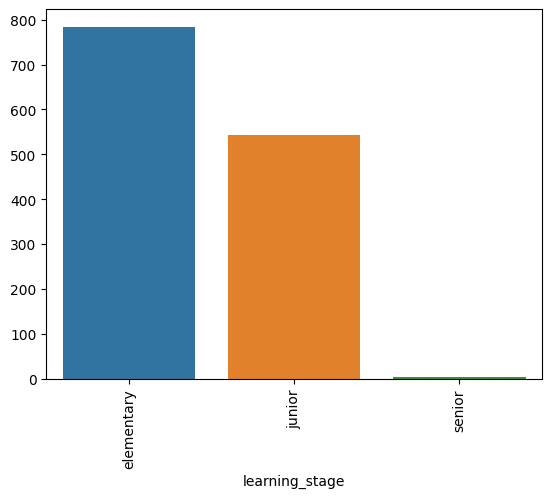

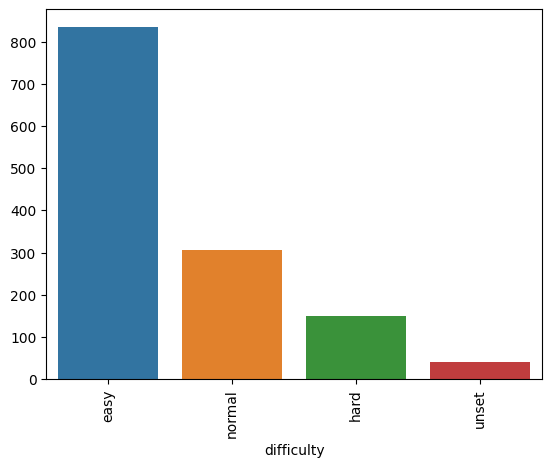

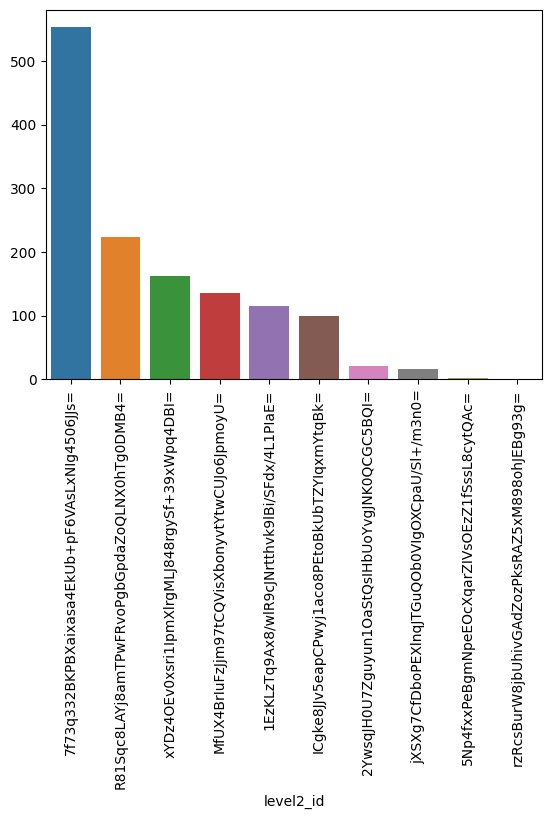

In [3]:
explore(content_data, "content")

                                           uuid gender user_city  user_grade  \
0  Y2RcCdmUJAYPUAIDElo4nE9KrkLLFzUIRdexG+ipaZQ=   None        kh           1   
1  lw/Rchfvl9q1UDaQRmeE6QJDJeXAK7nt56RvUvqxD/8=   None      ntpc           1   
2  ncVYyCw3osV77X9M+4NbI7LvBR5UiB4ix6Ca+baQArA=   male        tp           1   
3  J7Tbo1x2WtRpPuXeX7lWT9tkzWlSJeubl8UWjNmHh+4=   None      ntpc           2   
4  qijKzROzz1LmCaCxHJ3mOBOtjW/q4kW80tnpPmXHVYQ=   None        km           2   

   points  badges_cnt first_login_date_tw  
0   18300           1          2019-01-24  
1    6468           0          2019-01-24  
2    4703           0          2019-01-24  
3   15525           1          2019-01-24  
4    7945           0          2019-01-24  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72758 entries, 0 to 72757
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   uuid                 72758 n

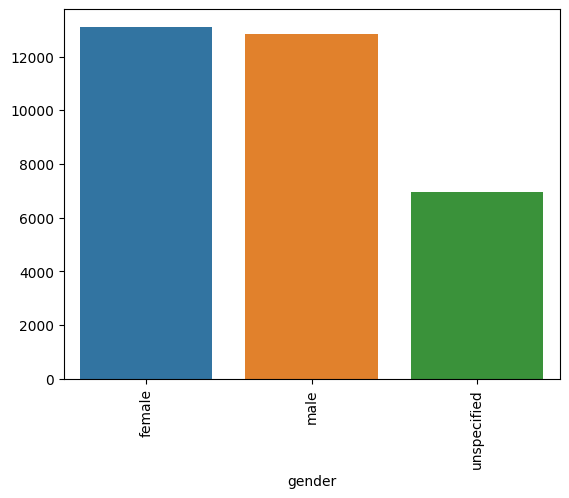

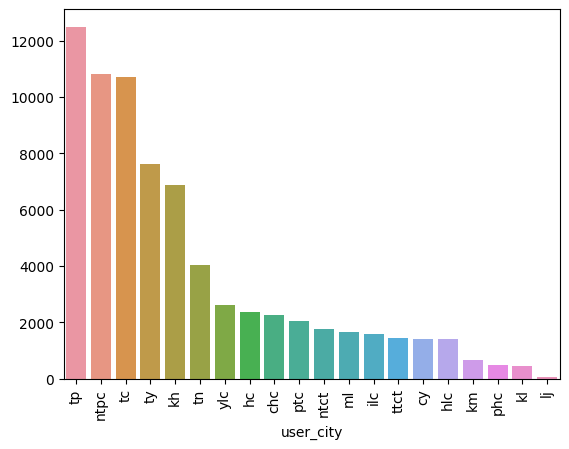

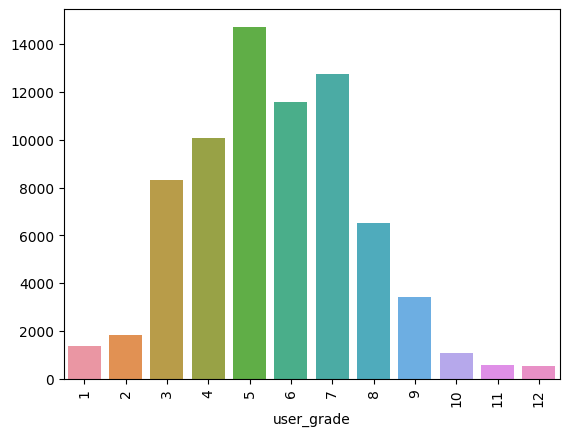

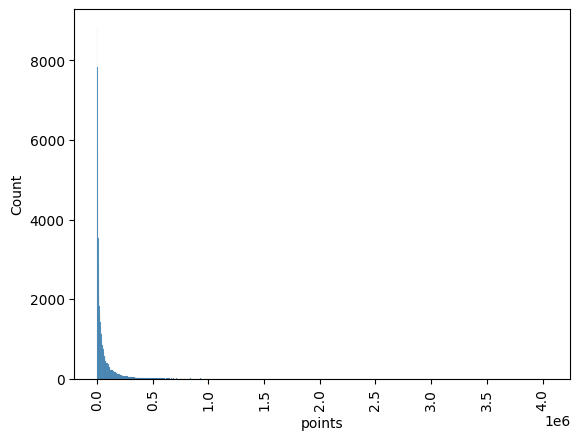

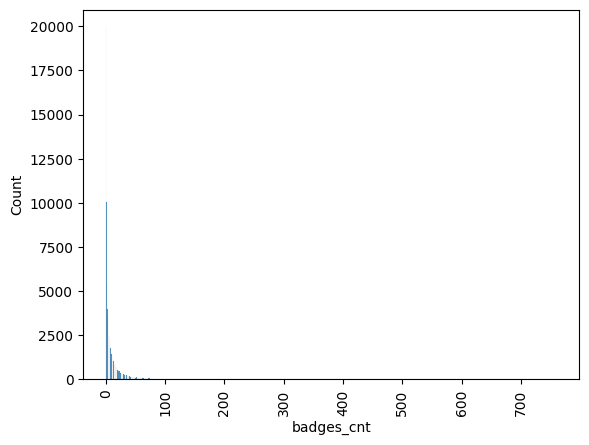

In [4]:
explore(user_data, "user")

         timestamp_tw                                          uuid  \
0 2019-06-17 19:15:00  ObmhvvrPGcrDyhjtdyUeeYllcexOdTPcvP6Cw12bWFM=   
1 2019-06-17 19:45:00  Kpq2q+eKw/O+6/jLs3XJosgmI7weEJxJZdnkKTbbF8I=   
2 2019-06-18 19:30:00  deOZPoZ4Yd2BwBBjxGNaMAub6M5zuA7/0i+vkGj7V40=   
3 2019-06-22 07:45:00  /Bho23u/erMsS8TZP0wjMYmdpp0g5UFFEnAgopSEDLg=   
4 2019-06-11 16:15:00  Db5veyf0JuPvYPt6QV2l2KMCesL0bKp5e/8Q6PJLFvo=   

                                           ucid  \
0  /acOsfJkQuYuDq5UjkRrojhkbUcIgia4SvjKpo1v0pI=   
1  r+zxAQRiz0ZWhEixJ4ZiWlG2jDpl2qTa2mJ5ZnrVXA8=   
2  jpb1rgDXjbe7vvSvZzIoPtn6mVIKPxauQ1QVTvzkAdw=   
3  Uq0Jd5CXS1nkLOvMSauJ2/DL+7ZrSiFIXAs+Y0LWrjA=   
4  daGwNLwnh35rFVqjg4maa1tVsx+wdDt7V9HggGCDZXI=   

                                           upid  problem_number  \
0  ttLI3ByLCW4eCTN6sLClpblFHzoP5PGVWkE45ZruVbc=              14   
1  +5Gnf/7APi9Ef3UwKUNVbeleg9YRCsIp8qw2RzRlLx8=              16   
2  GaVLvEVxXWZbz1jwOvzpuSax8tOKD9tegkNCEfSnRLc=               6  

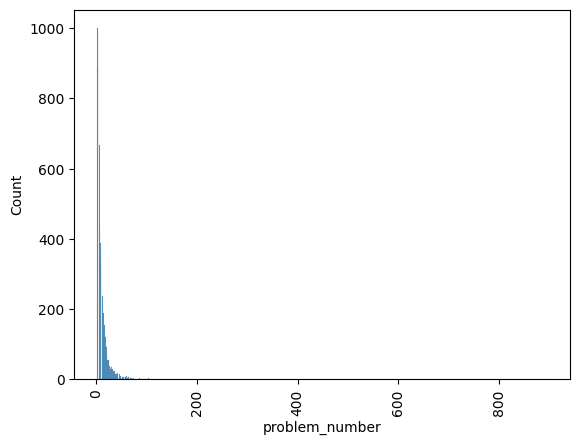

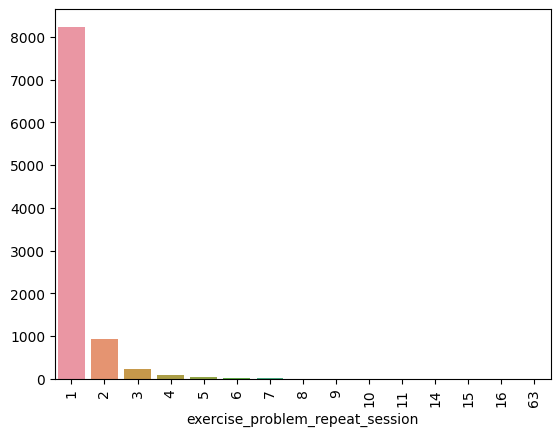

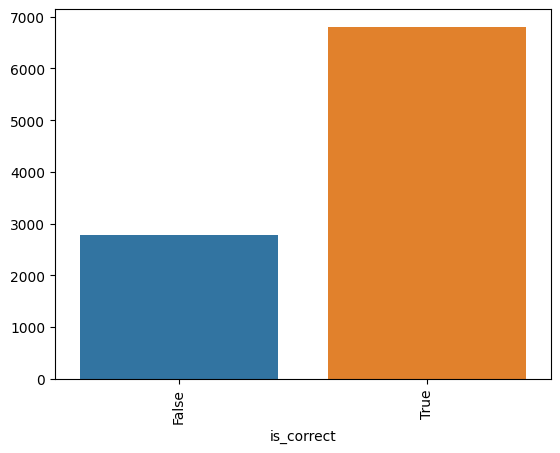

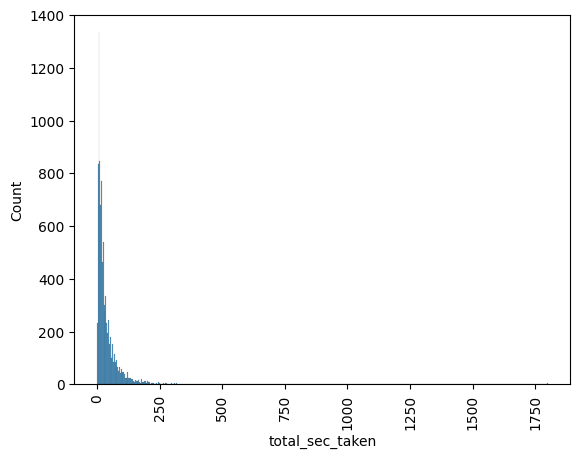

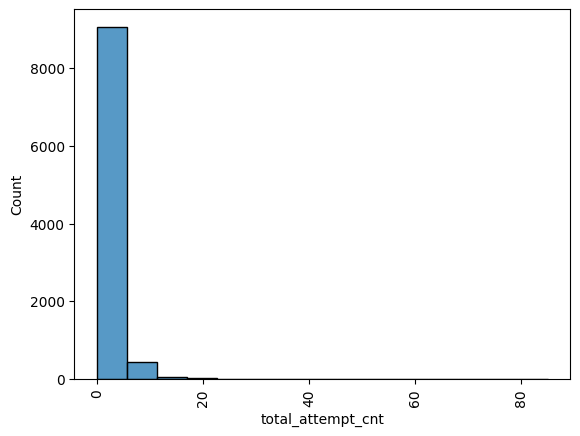

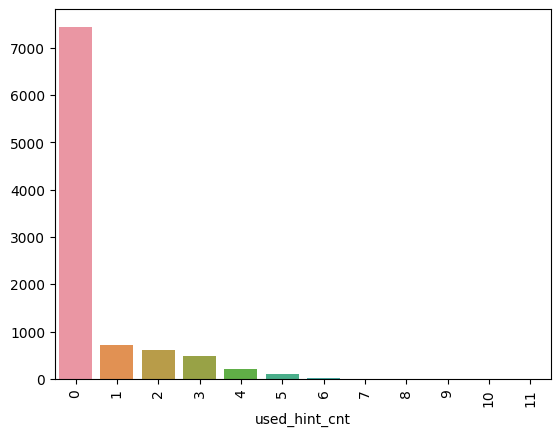

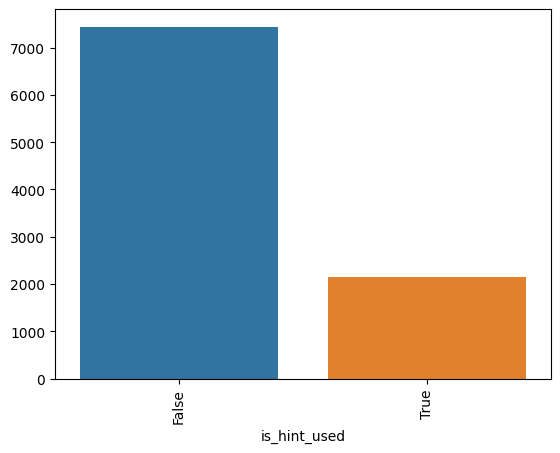

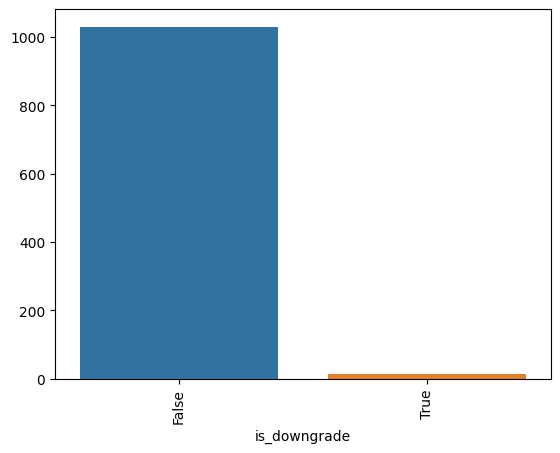

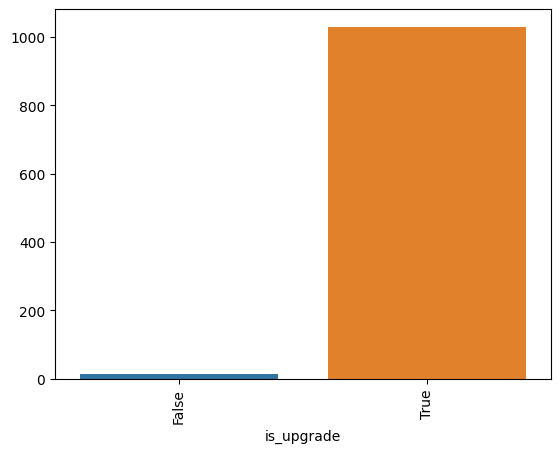

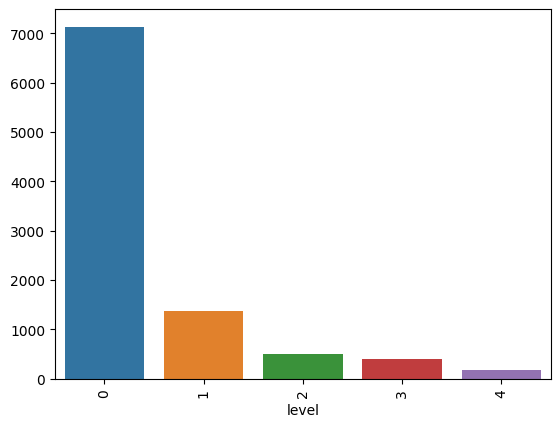

In [5]:
explore(log_data, "log")

Various insights:

* Students are more likely to do the exercises inline with the school time: this means non-holiday periods and weekdays, mostly around 4-5pm afterschool. They are less likely to do them during lunch or dinner time.

* Corr(Level, IsCorrect) = 0.25 (positive). It seems that the Proficiency Mechanism works.

## Next Plan

* [randomise the students?]
* Which problems are actually difficult (based on correctness, tot_sec_taken, level-frequency, etc)? (guess: stats/geo). Suggest learning progression. Predict unset difficulty.
* 
* Total second taken: why are some of them really long?

## Epilogue: Closing Connection

In [7]:
conn.close()